In [12]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clr
import argparse
import os

def r2_score(y, y_pred):
    """
    Calculate the R^2 score.
    """
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - ss_res / ss_tot

def distribution_function_mesa(z, Gamma, z1, z2):
    """
    Distribution function g(z) with a flat region, as given in Tagantsev et al. (2002).
    It is defined by the parameters z1, z2, and Γ.
    """
    def _distribution_function_mesa(z, Gamma, z1, z2):
        h = 1 / (z2 - z1 + Gamma * np.pi)
        if z < z1:
            return (Gamma**2 * h) / ((z - z1)**2 + Gamma**2)
        elif z > z2:
            return (Gamma**2 * h) / ((z - z2)**2 + Gamma**2)
        else:
            return h
        
    return np.vectorize(_distribution_function_mesa)(z, Gamma, z1, z2)
    
def distribution_function_lorentzian(z, A, omega, z_lorentz):
    """
    Distribution function g(z) with a Lorentzian shape, as used in Kondratyuk & Chouprik (2022).
    """
    def _distribution_function_lorentzian(z, A, omega, z_lorentz):
        return (A / np.pi) * (omega / ((z - z_lorentz)**2 + omega**2))
    
    #return np.vectorize(_distribution_function_lorentzian)(z, A, omega, z_lorentz)
    return _distribution_function_lorentzian(z, A, omega, z_lorentz)

def polarization_mesadist(t, Gamma, z1, z2):
    """
    Polarization function P(t) arising from a mesa-like distribution function g(z) as given in Tagantsev et al. (2002).
    """
    def _polarization_mesadist(t, Gamma, z1, z2):
        z0 = np.log10(t)
        h = 1 / (z2 - z1 + Gamma * np.pi)
        if z0 < z1:
            return Gamma * h * (np.pi/2 - np.arctan((z1 - z0) / Gamma))
        elif z0 > z2:
            return Gamma * h * (np.pi/2 + (z2-z1)/Gamma + np.arctan((z0 - z2) / Gamma))
        else:
            return Gamma * h * (np.pi/2 + (z0-z1)/Gamma)
        
    return np.vectorize(_polarization_mesadist)(t, Gamma, z1, z2)
    
def polarization_lorentzian(t, A, omega, z_lorentz, n):
    """
    Polarization function P(t) arising from a Lorentzian distribution function g(z) as used in Kondratyuk & Chouprik (2022).
    """
    def _integrand(z0, t, A, omega, zl, n):
        t0 = 10**z0
        return (1 - np.exp(-(t/t0)**n)) * distribution_function_lorentzian(z0, A, omega, zl)
    def _polarization_lorentzian(t, A, omega, zl, n):
        return 2 * quad(_integrand, zl-10*omega, zl+10*omega, args=(t, A, omega, zl, n), limit=100000)[0]
    
    return np.vectorize(_polarization_lorentzian)(t, A, omega, z_lorentz, n)

def fit_polarization(x, y, p0=None, bounds=None, type="mesa", pmax=None):
    """
    Fit the polarization data to a distribution function.
    """
    x = np.array(x)
    y = np.array(y)

    p = 1 if pmax is None else pmax
    def _func(x, *params):
        if type == "mesa":
            if params[1] > params[2]:
                return np.inf
            return p * polarization_mesadist(x, *params)
        elif type == "lorentzian":
            return p * polarization_lorentzian(x, *params)
        else:
            raise ValueError("Unknown type of distribution function")
        
    if bounds is None:
        bounds = (-np.inf, np.inf)
    
    popt, pcov = curve_fit(_func, x, y, p0=p0, bounds=bounds, nan_policy='omit')
    return popt

def f_tau(V, tau0, V0, n):
        return tau0 * np.exp((V0 / V)**n)

def fit_tau(voltage, log_tau, p0=None):
    """
    Fit the log of the characteristic time to a linear function of the voltage.
    """
    voltage = np.array(voltage)
    log_tau = np.array(log_tau)

    if p0 is None:
        p0 = [1e-9, 3, 2]

    bounds = ([-np.inf, 0, 0], [np.inf, np.inf, 4])
    #bounds = (-np.inf, np.inf)
    
    popt, pcov = curve_fit(lambda V, t0, V0, n: np.log(f_tau(V, t0, V0, n)), voltage, log_tau, p0=p0, bounds=bounds, nan_policy='omit')
    return popt

def iterative_fit(data, pmax=None, iters=10, p0_tmin=None, p0_tmax=None):
    """
    Fit polarization data, extract tau_min/max fit, and then use that to obtain better initial guesses for polarization fit.
    """
    # initial guess
    p0 = [0.2, -8, -7]
    optdata = {}
    popt_tmin = None
    popt_tmax = None

    bounds = ([1e-6, -12, -12], [10, 0, 0])

    for i in range(iters):
        optdata = {"voltage": [], "p0": [], "p1": [], "p2": []}
        for col in data.columns[1:]:
            # update initial guess
            if (popt_tmin is not None) and (popt_tmax is not None):
                tmin0 = np.log(f_tau(float(col), *popt_tmin))
                tmax0 = np.log(f_tau(float(col), *popt_tmax))
                p0 = [0.2, tmin0, tmax0]
            elif (popt_tmax is not None):
                tmax0 = np.log(f_tau(float(col), *popt_tmax))
                p0 = [0.2, tmax0-1, tmax0]
            elif (popt_tmin is not None):
                tmin0 = np.log(f_tau(float(col), *popt_tmin))
                p0 = [0.2, tmin0, tmin0+1]
            try:
                popt = fit_polarization(data['Pulse Width'], data[col], p0=p0, bounds=bounds, pmax=pmax[float(col)] if pmax is not None else None)
                # keep fit only if it looks reasonable
                if (popt is not None) and (popt[1] < popt[2]) and (popt[1] < 10) and (popt[2] < 10) and (popt[1] > -12) and (popt[2] > -12):
                    optdata["voltage"].append(float(col))
                    optdata["p0"].append(popt[0])
                    optdata["p1"].append(popt[1])
                    optdata["p2"].append(popt[2])
            except:
                pass

        # fit tau_min and tau_max
        try:
            popt_tmin = fit_tau(optdata["voltage"], optdata["p1"], p0=p0_tmin)
        except:
            pass
        try:
            popt_tmax = fit_tau(optdata["voltage"], optdata["p2"], p0=p0_tmax)
        except:
            pass

    return pd.DataFrame(optdata), popt_tmin, popt_tmax

def iterative_fit_lorentzian(data, pmax=None, iters=5, p0_lorentz=None):
    """
    Fit polarization data (lorentzian), extract tau_lorentz fit, and then use that to obtain better initial guesses for polarization fit.
    """
    # initial guess
    p0 = [0.2, 0.1, -7, 2]
    optdata = {}
    popt_tl = None                    

    bounds = ([0, 1e-11, -10, 0], [10, 0.9, 0, 3])
    iters = 1
    for i in range(iters):
        optdata = {"voltage": [], "p0": [], "p1": [], "p2": [], "p3": []}
        for col in data.columns[1:]:
            # update initial guess
            # if (popt_tl is not None):
            #     tl0 = np.log(f_tau(float(col), *popt_tl))
            #     p0 = [0.2, 0.1, tl0, popt_tl[2]]
            try:
                popt = fit_polarization(data['Pulse Width'], data[col], type="lorentzian", p0=p0, bounds=bounds, pmax=pmax[float(col)] if pmax is not None else None)
                # keep fit only if it looks reasonable
                if (popt is not None) and (popt[2] < 10) and (popt[2] > -12):
                    optdata["voltage"].append(float(col))
                    optdata["p0"].append(popt[0])
                    optdata["p1"].append(popt[1])
                    optdata["p2"].append(popt[2])
                    optdata["p3"].append(popt[3])

                print(f"Fit for {col}V: {popt}")
            except Exception as e:
                print("Failed to fit", col, e)

        # fit tau_lorentz
        try:
            popt_tl = fit_tau(optdata["voltage"], optdata["p1"], p0=p0_lorentz)
        except Exception as e:
            print("Failed to fit tau_lorentz", e)

    return pd.DataFrame(optdata), popt_tl


def plot_single(data, column, ax=None, fit=False, fit_type="mesa", p0=None, bounds=None, pmax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()

    popt = None
    if fit:
        ax.scatter(data['Pulse Width'], data[column], **kwargs)
        if p0 is None:
            if fit_type == "mesa":
                p0 = [0.2, np.log(f_tau(float(column), 1e-6, 4, 2)), np.log(f_tau(float(column), 1e-4, 4, 2))]
            else:
                p0 = [0.2, 0.1, -7, 2]
        if bounds is None:
            if fit_type == "mesa":
                bounds = ([1e-6, -12, -12], [10, 0, 0])
            else:
                bounds = ([0, 1e-11, -10, 0], [10, 0.9, 0, 3])
        try:
            popt = fit_polarization(data['Pulse Width'], data[column], p0=p0, bounds=bounds, type=fit_type, pmax=pmax)
        except Exception as e:
            print(f"Failed to fit {column}V: {e}")
            return
        t = np.logspace(np.log10(data['Pulse Width'].min()), np.log10(data['Pulse Width'].max()), 1000)
        if fit_type == "mesa":
            p = polarization_mesadist(t, *popt) * (pmax if pmax is not None else 1)
            r2 = r2_score(data[column], polarization_mesadist(data['Pulse Width'], *popt))
            label = f'{column}V: $\\Gamma$={popt[0]:.2f}, $\\log(\\tau_{{min}})$={popt[1]:.2f}, $\\log(\\tau_{{max}})$={popt[2]:.2f} ($R^2$={r2:.3f})'
        elif fit_type == "lorentzian":
            p = polarization_lorentzian(t, *popt) * (pmax if pmax is not None else 1)
            r2 = r2_score(data[column], polarization_lorentzian(data['Pulse Width'], *popt))
            label = f'{column}V: $A$={popt[0]:.2f}, $\\omega$={popt[1]:.2f}, $\\log(\\tau_{{Lorentz}})$={popt[2]:.2f}, $n$={popt[3]:.2f}, ($R^2$={r2:.3f})'
        else:
            raise ValueError("Unknown type of distribution function")
        ax.plot(t, p, ls='--', label=label, **kwargs)
    else:
        ax.plot(data['Pulse Width'], data[column], marker='o', **kwargs)

    if ax is None:
        ax.set(xlabel = 't', ylabel = 'p', xscale='log')
        plt.show()

    return popt

def plot_all(data, ax=None, cmap=plt.cm.plasma, fit=False, fit_type="mesa", pmax=None):
    # dictionary to store fit data
    optdata = {"voltage": [], "p0": [], "p1": [], "p2": []}

    if ax is None:
        fig, ax = plt.subplots()

    norm = clr.Normalize()       
    colors = cmap(norm(data.columns[1:].astype(float)))
    cbar = plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax)
    cbar.set_label("V")
    
    for col, c in zip(data.columns[1:], colors):           
        popt = plot_single(data, col, ax=ax, fit=fit, color=c, fit_type=fit_type, pmax=pmax[float(col)] if pmax is not None else None)
        if fit and popt is not None:
            optdata["voltage"].append(float(col))
            optdata["p0"].append(popt[0])
            optdata["p1"].append(popt[1])
            optdata["p2"].append(popt[2])

    if ax is None:
        ax.set(xlabel = 't', ylabel = 'p', xscale='log')
        plt.show()
    
    return pd.DataFrame(optdata)

def plot_all_iterative(data, axs, pmax=None, cmap=plt.cm.plasma, iters=5, p0_tmin=None, p0_tmax=None, fit_type="mesa"):
    if fit_type == "mesa":
        opt_df, popt_tmin, popt_tmax = iterative_fit(data, pmax=pmax, iters=iters, p0_tmin=p0_tmin, p0_tmax=p0_tmax)
    else:
        opt_df, popt_tl = iterative_fit_lorentzian(data, pmax=pmax, iters=iters, p0_lorentz=p0_tmin)

    norm = clr.Normalize()       
    colors = cmap(norm(data.columns[1:].astype(float)))
    #cbar = plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm), ax=axs[0])
    #cbar.set_label("V")
    
    for col, c in zip(data.columns[1:], colors):
        axs[0].scatter(data['Pulse Width'], data[col], color=c)
        if float(col) in opt_df['voltage'].values:
            popt = opt_df[opt_df['voltage'] == float(col)]
            t = np.logspace(np.log10(data['Pulse Width'].min()), np.log10(data['Pulse Width'].max()), 1000)
            if fit_type == "mesa":
                gamma, z1, z2 = popt['p0'].values[0], popt['p1'].values[0], popt['p2'].values[0]
                label = f'{col}V: $\\Gamma$={gamma:.2f}, $\\log(\\tau_{{min}})$={z1:.2f}, $\\log(\\tau_{{max}})$={z2:.2f}'
                p = polarization_mesadist(t, gamma, z1, z2) * (pmax[float(col)] if pmax is not None else 1)
            else:
                A, omega, zl, n = popt['p0'].values[0], popt['p1'].values[0], popt['p2'].values[0], popt['p3'].values[0]
                label = f'{col}V: $A$={A:.2f}, $\\omega$={omega:.2f}, $\\log(\\tau_{{Lorentz}})$={zl:.2f}, $n$={n:.2f}'
                p = polarization_lorentzian(t, A, omega, zl, n) * (pmax[float(col)] if pmax is not None else 1)
            axs[0].plot(t, p, ls='--', color=c, label=label)

    v = np.linspace(opt_df['voltage'].min(), opt_df['voltage'].max(), 1000)

    if fit_type == "mesa":
        axs[1].scatter(opt_df['voltage'], opt_df['p1'], color='C0', label='$\\log(\\tau_{{min}})$ (exp.)')
        axs[1].scatter(opt_df['voltage'], opt_df['p2'], color='C1', label='$\\log(\\tau_{{max}})$ (exp.)')

        if popt_tmin is not None:
            tmin = f_tau(v, *popt_tmin)
            axs[1].plot(v, np.log(tmin), ls='--', color='C0',
                        label=f'$\\log(\\tau_{{min}})$ (fit): $\\tau_0$={popt_tmin[0]:.2e}, $V_0$={popt_tmin[1]:.2f}, $n$={popt_tmin[2]:.2f}')
        if popt_tmax is not None:
            tmax = f_tau(v, *popt_tmax)
            axs[1].plot(v, np.log(tmax), ls='--', color='C1',
                        label=f'$\\log(\\tau_{{max}})$ (fit): $\\tau_0$={popt_tmax[0]:.2e}, $V_0$={popt_tmax[1]:.2f}, $n$={popt_tmax[2]:.2f}')
            
        return opt_df, popt_tmin, popt_tmax
            
    else:
        axs[1].scatter(opt_df['voltage'], opt_df['p2'], color='C0', label='$\\log(\\tau_{{Lorentz}})$ (exp.)')
        if popt_tl is not None:
            tl = f_tau(v, *popt_tl)
            axs[1].plot(v, np.log(tl), ls='--', color='C0',
                        label=f'$\\log(\\tau_{{Lorentz}})$ (fit): $\\tau_0$={popt_tl[0]:.2e}, $V_0$={popt_tl[1]:.2f}, $n$={popt_tl[2]:.2f}')
            
        return opt_df, popt_tl

def load_data(filename):
    """
    Load data in the format of the provided CSV file.
    The first column is pulse width, and the even columns (starting from 0) are the polarization values for each voltage.
    """
    data = pd.read_csv(filename)
    # keep only even columns
    data = data.iloc[:, ::2]
    # fix column names
    data.columns = [col.split('V')[0] for col in data.columns]
    # convert all the numeric values to float
    data = data.apply(pd.to_numeric, errors='coerce')
    # clip negative values to 0
    data = data.clip(lower=0)
    # normalize the data
    data = data.div(data.max().max())
    
    return data

def get_pmax(filename):
    df = load_data(filename)
    maxpols = df.max()
    maxpols = maxpols[1:]
    maxpols.to_csv(os.path.join(os.path.dirname(filename), os.path.join("maxpols", os.path.basename(filename))), index_label='V', header=['Pmax'])

Fit for 1.00V: [ 6.31875181e-01  3.36058577e-03 -2.13226854e-08  4.43170562e-02]
Failed to fit 1.25 Optimal parameters not found: The maximum number of function evaluations is exceeded.
Failed to fit 1.50 Optimal parameters not found: The maximum number of function evaluations is exceeded.
Fit for 1.75V: [ 0.56926227  0.06910588 -5.19447418  1.83170789]
Fit for 2.00V: [ 0.54319633  0.11982297 -5.55406882  1.0047569 ]
Fit for 2.25V: [ 0.45496065  0.0442906  -6.38749892  1.19101953]
Fit for 2.50V: [ 0.5091816   0.18848043 -6.69445768  1.74290115]
Fit for 2.75V: [ 5.05171413e-01  1.68922284e-09 -7.03420003e+00  8.06706952e-01]
Fit for 3.00V: [ 0.52313859  0.20052956 -7.42737468  2.873761  ]
Fit for 3.25V: [ 0.5260982   0.20700312 -7.7408916   1.77990749]
Fit for 3.50V: [ 0.49551057  0.04450464 -7.9133684   1.52530142]
Fit for 3.75V: [ 0.52688502  0.11183133 -8.02163787  1.60833415]
Fit for 4.00V: [ 5.25817964e-01  2.24969379e-08 -8.09472458e+00  1.57554291e+00]
Fit for 4.25V: [ 5.26055054

/tmp/ipykernel_492276/3799789018.py:114: RuntimeWarning: invalid value encountered in log
  popt, pcov = curve_fit(lambda V, t0, V0, n: np.log(f_tau(V, t0, V0, n)), voltage, log_tau, p0=p0, bounds=bounds, nan_policy='omit')
/tmp/ipykernel_492276/3799789018.py:99: RuntimeWarning: overflow encountered in exp
  return tau0 * np.exp((V0 / V)**n)
/tmp/ipykernel_492276/401533494.py:19: RuntimeWarning: invalid value encountered in log
  popt, pcov = curve_fit(lambda V, t0, V0, n: np.log(f_tau(V, t0, V0, n)), voltages, log_taus)
/tmp/ipykernel_492276/3799789018.py:99: RuntimeWarning: invalid value encountered in power
  return tau0 * np.exp((V0 / V)**n)


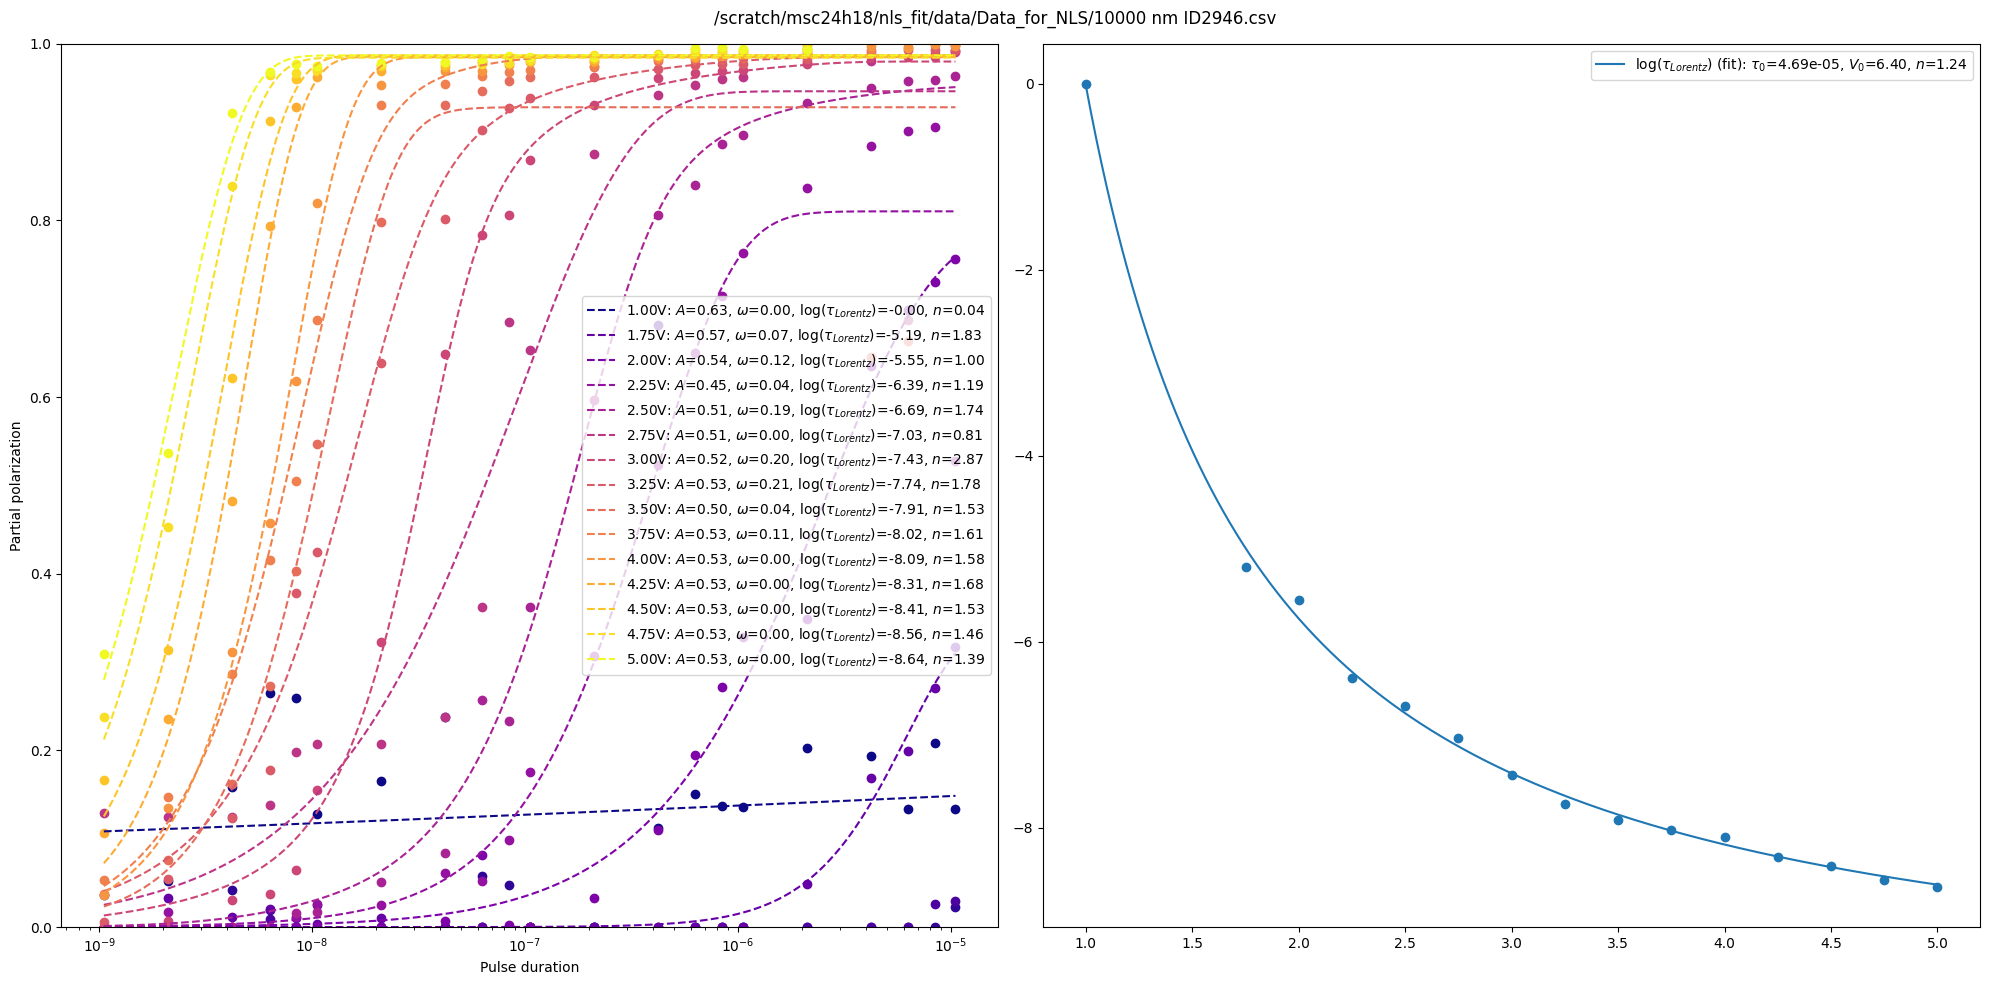

In [37]:
DATA_PATH = '/scratch/msc24h18/nls_fit/data/Data_for_NLS/10000 nm ID2946.csv'
PMAX_PATH = '/scratch/msc24h18/nls_fit/data/Data_for_NLS/maxpols/10000 nm ID2946.csv'

data = load_data(DATA_PATH)
pmax = np.loadtxt(PMAX_PATH, delimiter=',', skiprows=1)
pmax = {float(v): min(p*1.05, 1) for v, p in pmax}

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(DATA_PATH)
opt_df, popt_tl = plot_all_iterative(data, axs, pmax=pmax, p0_tmin=None, p0_tmax=None, fit_type="lorentzian")
axs[0].set(xlabel = 'Pulse duration', ylabel = 'Partial polarization', xscale='log', ylim=(0, 1))
axs[0].legend()
axs[1].clear()

voltages = opt_df['voltage'].values
log_taus = opt_df['p2'].values

axs[1].scatter(opt_df['voltage'], opt_df['p2'])
popt, pcov = curve_fit(lambda V, t0, V0, n: np.log(f_tau(V, t0, V0, n)), voltages, log_taus)
v = np.linspace(voltages.min(), voltages.max(), 1000)
t = f_tau(v, *popt)
axs[1].plot(v, np.log(t), label=f'$\\log(\\tau_{{Lorentz}})$ (fit): $\\tau_0$={popt[0]:.2e}, $V_0$={popt[1]:.2f}, $n$={popt[2]:.2f}')

axs[1].legend()
plt.tight_layout()
plt.show()

[4.68624421e-05 6.39672768e+00 1.23809783e+00]


/tmp/ipykernel_492276/3799789018.py:99: RuntimeWarning: overflow encountered in exp
  return tau0 * np.exp((V0 / V)**n)
/tmp/ipykernel_492276/3433458342.py:6: RuntimeWarning: invalid value encountered in log
  popt, pcov = curve_fit(lambda V, t0, V0, n: np.log(f_tau(V, t0, V0, n)), voltages, log_taus)
/tmp/ipykernel_492276/3799789018.py:99: RuntimeWarning: invalid value encountered in power
  return tau0 * np.exp((V0 / V)**n)


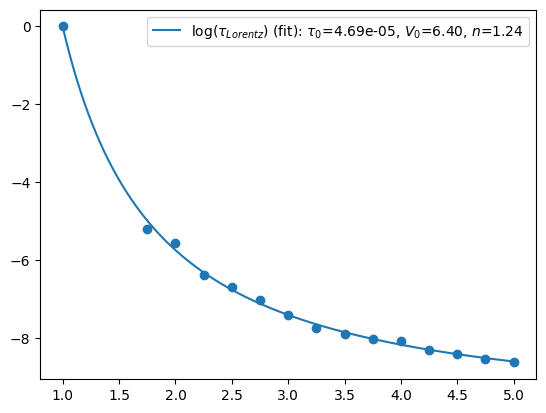

In [35]:
voltages = opt_df['voltage'].values
log_taus = opt_df['p2'].values

plt.scatter(voltages, log_taus)

popt, pcov = curve_fit(lambda V, t0, V0, n: np.log(f_tau(V, t0, V0, n)), voltages, log_taus)

v = np.linspace(voltages.min(), voltages.max(), 1000)
t = f_tau(v, *popt)
plt.plot(v, np.log(t), label=f'$\\log(\\tau_{{Lorentz}})$ (fit): $\\tau_0$={popt[0]:.2e}, $V_0$={popt[1]:.2f}, $n$={popt[2]:.2f}')
print(popt)
plt.legend()
plt.show()